# Import pacakges

In [12]:
from QEB import *
from scipy.stats import chi2
import numpy as np
from tqdm.auto import tqdm

# Simulation

### Simple simulation (contaminated ratio = 0.2)

In [6]:
START_RAD = 0
MAX_RAD = 1
GAP = 0.2

Create data

In [7]:
wqeb = WQEB(start_radius=START_RAD, max_radius=MAX_RAD, gap=GAP)
_ = wqeb.create_data(
            group_num=2, 
            group_name=["A", "B"], 
            contained_ratio_data=0.2, 
            contained_ratio_beta=0.2, 
            in_group_num=5
            )

Fit our model

In [8]:
_ = wqeb.paramters_initial()
betas_WEB, histories = wqeb.WEB_iter(max_iter=20, alpha=0.5, gamma=0.5)

  0%|          | 0/2 [00:00<?, ?it/s]

Plot results

In [9]:
estimated_densities = caculate_density(wqeb.distances_to_center, wqeb.betas_WEB, separated=True)

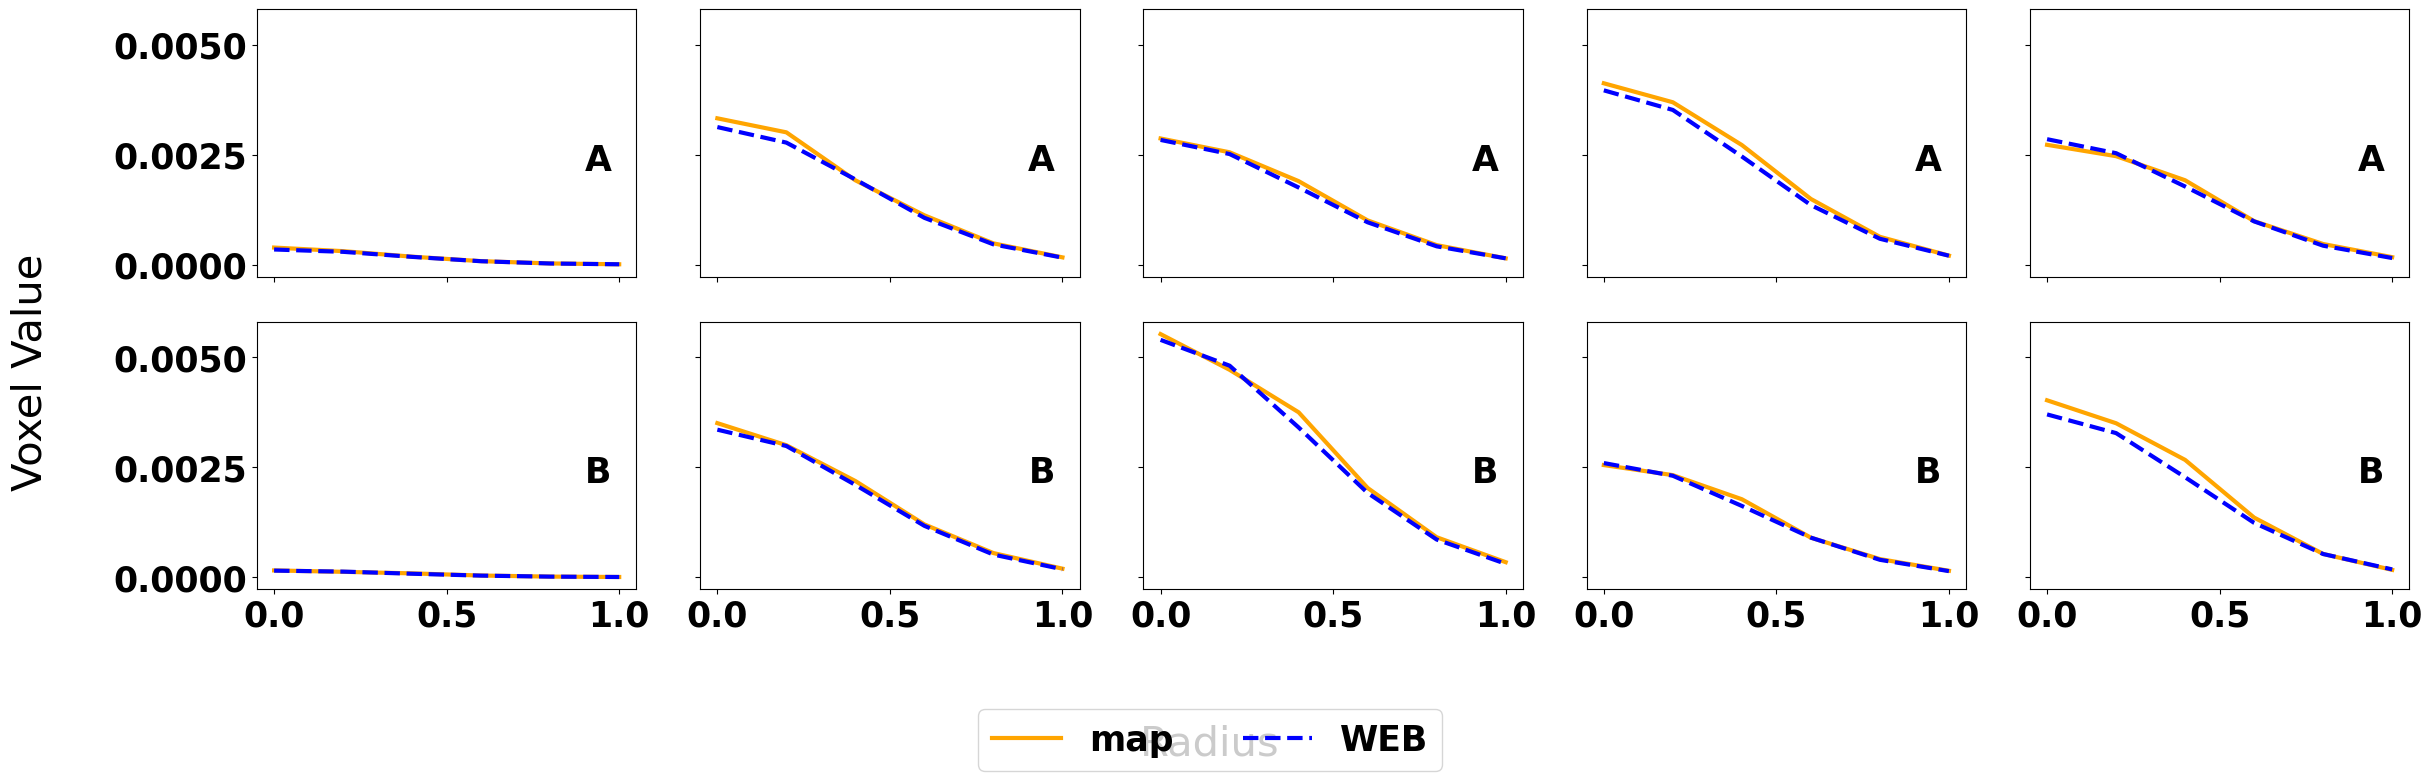

In [10]:
plot_density(
    wqeb.densities_data, 
    estimated_densities, 
    START_RAD,
    MAX_RAD,
    GAP,
    labels = ["WEB"],
    colors = ["blue"],
    subplots_num = 10,
    separated=True)

### Generalized simulation (contaminated ratio change)

Initial value

In [11]:
NUM = 10
IN_GROUP_NUM = 50

Create data and fit our model

In [13]:
mse_0_WEB = np.zeros((NUM, NUM))
mse_1_WEB = np.zeros((NUM, NUM))
mse_hyper_WEB = np.zeros((NUM, NUM))

wqeb = WQEB(start_radius=START_RAD, max_radius=MAX_RAD, gap=GAP)
for i in tqdm(range(NUM)):
    contained_ratio_beta = 0.05 * i
    for j in range(NUM):
        contained_ratio_data = 0.05 * j
        wqeb.create_data(
            group_num=1, 
            group_name=["A"], 
            contained_ratio_data=contained_ratio_data, 
            contained_ratio_beta=contained_ratio_beta, 
            in_group_num=IN_GROUP_NUM
            )
        wqeb.paramters_initial()
        wqeb.WEB_iter(max_iter=20, alpha=contained_ratio_data, gamma=contained_ratio_beta, verbose=False)
        
        mse_0_WEB[i][j], mse_1_WEB[i][j] = np.mean((wqeb.betas["A"] - wqeb.betas_WEB["A"])**2, axis=0)
        mse_hyper_WEB[i][j] = np.sum((wqeb.mus["A"] - wqeb.mus_mle["A"])**2) / 2

  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

Plot Results

In [ ]:
simulation_plot(mse_hyper_WEB, "MSE", "MSE of Hyperparameter")
simulation_plot(mse_0_WEB + mse_1_WEB, "MSE", "MSE of Beta")